# Capstone 3 - Exploratory Data Analysis

Before moving on to modeling, we need to determine whether a transformers based language model can capture chronological information about Biblical Hebrew. To do so, I will train a language model for biblical Hebrew, create sentence embeddings for the labeled verses, and then plot the first two principal components of each embedding. If the language model does capture chronological information about the Hebrew language, then the different chronological phases should form (relatively) discrete clusters. 

In [17]:
#import the necessary packages

import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import RobertaTokenizerFast, AutoTokenizer, RobertaForMaskedLM, AutoConfig, DataCollatorForLanguageModeling, Trainer, TrainingArguments, AutoModelForMaskedLM, pipeline
from datasets import load_dataset
from huggingface_hub import notebook_login
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import confusion_matrix

In [55]:
#load the data

df = pd.read_csv('HebrewBiblebyVerse.csv', index_col='Verse')

df.tail()

,Text
Verse,
2 Chr 36:19,wa yiśrəpû ʔet bêt hā ʔĕlōhîm wa yənattəṣû...
2 Chr 36:20,wa yegel ha šəʔērît min ha ḥereb ʔel bābe...
2 Chr 36:21,lə mallôt dəbar yəhwāh bə pî yirməyāhû ʕa...
2 Chr 36:22,û bi šənat ʔaḥat lə kôreš melek pāras li ...
2 Chr 36:23,kō ʔāmar kôreš melek pāras kol mamləkôt ...


## Training the Tokenizer

I've decided to use the RoBERTa architecture for my language model. It is well suited to the task of classifying biblical Hebrew texts because it: 1) employs a byte-level BPE tokenizer that supports diacritics and 2) is auto-encoding.

The names of most BERT-style models contain a play on the word BERT (e.g., RoBERTa, CameBERT, etc.). I've continued this tradition by naming my model BERiT after the biblical Hebrew word for 'covenant', bərît. 

In [23]:
verses = df['Text'].tolist()

verses[:11]

['bə rēšît  bārā  ʔĕlōhîm  ʔēt  ha šāmayim  wə ʔēt  hā ʔāreṣ',
 'wə hā ʔāreṣ  hāyətā  tōhû  wā bōhû  wə ḥōšek  ʕal  pənê  təhôm  wə rûaḥ  ʔĕlōhîm  məraḥepet  ʕal  pənê  ha māyim',
 'wa yōmer  ʔĕlōhîm  yəhî  ʔôr  wa yəhî  ʔôr',
 'wa yar  ʔĕlōhîm  ʔet  hā ʔôr  kî  ṭôb  wa yabdēl  ʔĕlōhîm  bên  hā ʔôr  û bên  ha ḥōšek',
 'wa yiqrā  ʔĕlōhîm  lā  ʔôr  yôm  wə la  ḥōšek  qārā  lāyəlā  wa yəhî  ʕereb  wa yəhî  bōqer  yôm  ʔeḥād',
 'wa yōmer  ʔĕlōhîm  yəhî  rāqîaʕ  bə tôk  ha māyim  wi yhî  mabdîl  bên  mayim  lā māyim',
 'wa yaʕaś  ʔĕlōhîm  ʔet  hā rāqîaʕ  wa yabdēl  bên  ha mayim  ʔăšer  mi taḥat  lā  rāqîaʕ  û bên  ha mayim  ʔăšer  mē ʕal  lā  rāqîaʕ  wa yəhî  kēn',
 'wa yiqrā  ʔĕlōhîm  lā  rāqîaʕ  šāmāyim  wa yəhî  ʕereb  wa yəhî  bōqer  yôm  šēnî',
 'wa yōmer  ʔĕlōhîm  yiqqāwû  ha mayim  mi taḥat  ha šāmayim  ʔel  māqôm  ʔeḥād  wə tērāʔê  ha yabbāšā  wa yəhî  kēn',
 'wa yiqrā  ʔĕlōhîm  la  yabbāšā  ʔereṣ  û lə miqwē  ha mayim  qārā  yammîm  wa yar  ʔĕlōhîm  kî  ṭôb',
 'wa yōmer  ʔĕlōhîm  

In [24]:
def get_training_corpus():
    dataset = verses
    for start_idx in range(0, len(dataset), 1000):
        samples = dataset[start_idx : start_idx + 1000]
        yield samples
        
training_corpus = get_training_corpus()

In [25]:
old_tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')
tokenizer = old_tokenizer.train_new_from_iterator(training_corpus, 52000)

In [26]:
tokenizer.save_pretrained("BERiT")

('BERiT/tokenizer_config.json',
 'BERiT/special_tokens_map.json',
 'BERiT/vocab.json',
 'BERiT/merges.txt',
 'BERiT/added_tokens.json',
 'BERiT/tokenizer.json')

## Training the Language Model

Training the language model involves several steps: first, we need to divide the raw data into train and test sets; second, we need to tokenize both datasets; and third, we need to run the training program. 

In [7]:
tokenizer = AutoTokenizer.from_pretrained("BERiT")

In [27]:
train_data, test_data = train_test_split(df, test_size=.005, random_state=42)

In [28]:
train_data.to_csv('trainingdata.csv')

In [29]:
test_data.to_csv('testingdata.csv')

In [30]:
raw_dataset = load_dataset("csv", data_files={'train' : 'trainingdata.csv', 'test' : 'testingdata.csv'})

Using custom data configuration default-1fd2143f68edfd0e


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /Users/aw20/.cache/huggingface/datasets/csv/default-1fd2143f68edfd0e/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [31]:
def tokenize(element):
    return tokenizer(element['Text'])

In [32]:
tokenized_dataset = raw_dataset.map(tokenize, batched=True, remove_columns=raw_dataset['train'].column_names)

  0%|          | 0/23 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [33]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids'],
        num_rows: 22831
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids'],
        num_rows: 115
    })
})

In [34]:
config = AutoConfig.from_pretrained("roberta-base", 
                                    vocab_size=len(tokenizer), 
                                    n_ctx=128, 
                                    bos_token_id=0, 
                                    eos_toke_id=2)

In [35]:
model = RobertaForMaskedLM(config)

In [36]:
tokenizer.pad_token = tokenizer.eos_token

data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=True, mlm_probability=.15)

In [ ]:
notebook_login()

In [ ]:
args = TrainingArguments(output_dir="BERiTmodel2", 
                         per_device_train_batch_size=8,
                         evaluation_strategy="epoch",
                         num_train_epochs=10,
                         weight_decay=.1,
                         warmup_steps=280,
                         lr_scheduler_type="cosine",
                         push_to_hub=True
                        )

trainer = Trainer(model=model, 
                  tokenizer=tokenizer, 
                  args=args, 
                  data_collator=data_collator, 
                  train_dataset=tokenized_dataset['train'],
                  eval_dataset=tokenized_dataset['test'])

To speed up processing, I ran the training in a Google Colab Pro Notebook on a Tesla P100 GPU. The results of the training can be found here: https://huggingface.co/gngpostalsrvc/BERiTmodel2. 

In [ ]:
trainer.train()

In [ ]:
notebook_login()

In [ ]:
trainer.push_to_hub()

Let's check whether the training actually worked using a few examples.

In [37]:
mask_fill = pipeline("fill-mask", "gngpostalsrvc/BERiTmodel2")

In [38]:
mask_fill('wa yōmer <mask>')

[{'sequence': 'wa yōmer ʔēl',
  'score': 0.033486366271972656,
  'token': 190,
  'token_str': ' ʔēl'},
 {'sequence': 'wa yōmer ʔmōr',
  'score': 0.025586122646927834,
  'token': 326,
  'token_str': ' ʔmōr'},
 {'sequence': 'wa yōmer ʔlōhîm',
  'score': 0.02042512036859989,
  'token': 1404,
  'token_str': ' ʔlōhîm'},
 {'sequence': 'wa yōmer ʔēlay',
  'score': 0.010830204002559185,
  'token': 607,
  'token_str': ' ʔēlay'},
 {'sequence': 'wa yōmer yōmar',
  'score': 0.00733175640925765,
  'token': 993,
  'token_str': ' yōmar'}]

Awesome! The model identified five common and plausible options for the masked word: 
    
1. And he said to...
2. And he said, "Say...!"
3. And God said, "..."
4. And he said to me...
5. And he said, "He will say..."

Let's try another example.

In [39]:
mask_fill('ha māqôm  ha <mask>')

[{'sequence': 'ha māqôm  ha zê',
  'score': 0.45529893040657043,
  'token': 285,
  'token_str': ' zê'},
 {'sequence': 'ha māqôm  ha hû',
  'score': 0.05017251893877983,
  'token': 255,
  'token_str': ' hû'},
 {'sequence': 'ha māqôm  ha šəbîʕî',
  'score': 0.017493825405836105,
  'token': 1897,
  'token_str': ' šəbîʕî'},
 {'sequence': 'ha māqôm  ha yôm',
  'score': 0.016817649826407433,
  'token': 246,
  'token_str': ' yôm'},
 {'sequence': 'ha māqôm  ha šəlîšî',
  'score': 0.015264025889337063,
  'token': 2509,
  'token_str': ' šəlîšî'}]

Great! The top two options are incredibly common in the Hebrew Bible, and in two of the remaining cases, the model correctly identifies the masked word as an adjective: 

1. This place
2. That place
3. The seventh place
4. The place today
5. The third place

## Creating Sentence Embeddings for the Labeled Verses

With the model fully trained, we're ready to create sentence embeddings for the labeled verses. Because the model outputs sentence embeddings as the final hidden state, I've defined a helper function to retrieve this information. 

In [40]:
labeled_verses = pd.read_csv('labeled_verses.csv', index_col='Verse')

In [41]:
tokenizer = AutoTokenizer.from_pretrained("gngpostalsrvc/BERiTmodel2")

In [42]:
model = AutoModelForMaskedLM.from_pretrained("gngpostalsrvc/BERiTmodel2", output_hidden_states=True)

In [43]:
def embedder(sentence):
    sentence_ids = tokenizer.encode(sentence, return_tensors="pt")
    with torch.no_grad():
        out=model(input_ids=sentence_ids)
    return out[-1][-1][0][0].numpy()

In [44]:
model.eval()

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(47460, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNor

In [45]:
labeled_verses['Vector'] = labeled_verses['Text'].apply(embedder)

labeled_verses.head()

,Text,Stage,Vector
Verse,,,
Gen 49:2,hiqqābəṣû wə šimʕû bənê yaʕăqōb wə šimʕû ...,Archaic Biblical Hebrew,"[0.46415704, -0.4942218, 0.6977963, -2.0022402..."
Gen 49:3,rəʔûbēn bəkōrî ʔattā kōḥî wə rēšît ʔônî ...,Archaic Biblical Hebrew,"[0.4386284, -1.0689656, 0.060051218, -0.477384..."
Gen 49:4,paḥaz ka mayim ʔal tôtar kî ʕālîtā mišk...,Archaic Biblical Hebrew,"[0.6809253, -0.5653717, -0.65205204, 0.3617503..."
Gen 49:5,šimʕôn wə lēwî ʔaḥîm kəlê ḥāmās məkērōtêhem,Archaic Biblical Hebrew,"[0.8138547, -0.29978186, 0.0937625, -0.3093038..."
Gen 49:6,bə sōdām ʔal tābō napšî bi qəhālām ʔal t...,Archaic Biblical Hebrew,"[0.573014, -0.111786075, -0.63449097, 0.814129..."


I then split the components of each embedding vector into separate columns. This will make principal component analysis easier. 

In [46]:
X = labeled_verses.Vector.apply(pd.Series)

X.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
Verse,,,,,,,,,,,,,,,,,,,,,
Gen 49:2,0.464157,-0.494222,0.697796,-2.002240,-0.481948,-0.009591,-1.046462,-0.491135,-0.549707,-0.037399,...,0.359742,-0.149865,0.519176,-0.539552,-0.833575,-0.973837,0.454395,0.121786,0.292993,1.242339
Gen 49:3,0.438628,-1.068966,0.060051,-0.477385,-1.226976,-1.797044,-0.415015,0.217263,0.254980,0.376271,...,0.700247,-0.207136,0.079080,-0.241488,-0.290693,0.273426,0.195876,1.160682,-0.293586,1.955988
Gen 49:4,0.680925,-0.565372,-0.652052,0.361750,-1.093759,-1.675976,-0.151216,-1.094890,0.015146,1.112368,...,0.302197,0.198747,0.199398,0.874569,-0.498688,0.930374,-0.172042,1.351107,0.905352,1.003636
Gen 49:5,0.813855,-0.299782,0.093763,-0.309304,-1.499361,-1.831533,-0.121176,-0.892737,0.038607,0.253131,...,-0.491955,-0.178500,0.479455,0.930159,-0.282761,1.199329,0.527644,1.093994,-0.072787,2.475052
Gen 49:6,0.573014,-0.111786,-0.634491,0.814129,-0.737395,-1.424042,0.092141,-0.991415,0.701928,1.105433,...,0.036195,-0.794484,0.272742,0.718796,-0.528398,1.133588,-0.160358,0.229029,0.404836,0.819664


In [47]:
labeled_verses_vectorized = labeled_verses.merge(X, on='Verse')

labeled_verses_vectorized.drop(columns=['Text', 'Vector'], inplace=True)

labeled_verses_vectorized.head()

,Stage,0,1,2,3,4,5,6,7,8,...,758,759,760,761,762,763,764,765,766,767
Verse,,,,,,,,,,,,,,,,,,,,,
Gen 49:2,Archaic Biblical Hebrew,0.464157,-0.494222,0.697796,-2.002240,-0.481948,-0.009591,-1.046462,-0.491135,-0.549707,...,0.359742,-0.149865,0.519176,-0.539552,-0.833575,-0.973837,0.454395,0.121786,0.292993,1.242339
Gen 49:3,Archaic Biblical Hebrew,0.438628,-1.068966,0.060051,-0.477385,-1.226976,-1.797044,-0.415015,0.217263,0.254980,...,0.700247,-0.207136,0.079080,-0.241488,-0.290693,0.273426,0.195876,1.160682,-0.293586,1.955988
Gen 49:4,Archaic Biblical Hebrew,0.680925,-0.565372,-0.652052,0.361750,-1.093759,-1.675976,-0.151216,-1.094890,0.015146,...,0.302197,0.198747,0.199398,0.874569,-0.498688,0.930374,-0.172042,1.351107,0.905352,1.003636
Gen 49:5,Archaic Biblical Hebrew,0.813855,-0.299782,0.093763,-0.309304,-1.499361,-1.831533,-0.121176,-0.892737,0.038607,...,-0.491955,-0.178500,0.479455,0.930159,-0.282761,1.199329,0.527644,1.093994,-0.072787,2.475052
Gen 49:6,Archaic Biblical Hebrew,0.573014,-0.111786,-0.634491,0.814129,-0.737395,-1.424042,0.092141,-0.991415,0.701928,...,0.036195,-0.794484,0.272742,0.718796,-0.528398,1.133588,-0.160358,0.229029,0.404836,0.819664


As always, we'll save the data as csv for later use. 

In [48]:
labeled_verses_vectorized.to_csv('labeled_verses_vectorized.csv')

## Clustering the Labeled Verses

We're now in a position to determine if BERiT captures any chronological information about biblical Hebrew. We'll use PCA to reduce the 768 "features" of each verse embedding to the two most salient ones for visualization. 

In [3]:
pca = PCA(n_components=2, random_state=42)

In [4]:
labeled_verses_vectorized = pd.read_csv('labeled_verses_vectorized.csv', index_col='Verse')

labeled_verses_vectorized.head()

,Stage,0,1,2,3,4,5,6,7,8,...,758,759,760,761,762,763,764,765,766,767
Verse,,,,,,,,,,,,,,,,,,,,,
Gen 49:2,Archaic Biblical Hebrew,0.464157,-0.494222,0.697796,-2.002240,-0.481948,-0.009591,-1.046462,-0.491135,-0.549707,...,0.359742,-0.149865,0.519176,-0.539552,-0.833575,-0.973837,0.454395,0.121786,0.292993,1.242339
Gen 49:3,Archaic Biblical Hebrew,0.438628,-1.068966,0.060051,-0.477385,-1.226976,-1.797044,-0.415015,0.217263,0.254980,...,0.700247,-0.207136,0.079080,-0.241488,-0.290693,0.273426,0.195876,1.160682,-0.293586,1.955988
Gen 49:4,Archaic Biblical Hebrew,0.680925,-0.565372,-0.652052,0.361750,-1.093759,-1.675976,-0.151216,-1.094890,0.015146,...,0.302197,0.198747,0.199398,0.874569,-0.498688,0.930374,-0.172042,1.351107,0.905352,1.003636
Gen 49:5,Archaic Biblical Hebrew,0.813855,-0.299782,0.093762,-0.309304,-1.499361,-1.831533,-0.121176,-0.892737,0.038607,...,-0.491955,-0.178500,0.479455,0.930159,-0.282761,1.199329,0.527644,1.093994,-0.072787,2.475052
Gen 49:6,Archaic Biblical Hebrew,0.573014,-0.111786,-0.634491,0.814129,-0.737395,-1.424042,0.092141,-0.991415,0.701928,...,0.036195,-0.794484,0.272742,0.718796,-0.528398,1.133588,-0.160358,0.229029,0.404836,0.819664


In [54]:
pc = pd.DataFrame(pca.fit_transform(labeled_verses_vectorized.drop(columns='Stage')))

pc.columns = ['PC1', 'PC2']

pc['Stage'] = labeled_verses_vectorized.reset_index()['Stage']
pc['Verse'] = labeled_verses_vectorized.reset_index()['Verse']

pc.head()

,PC1,PC2,Stage,Verse
0,4.307147,-4.206573,Archaic Biblical Hebrew,Gen 49:2
1,10.307497,7.338330,Archaic Biblical Hebrew,Gen 49:3
2,11.916666,-2.727075,Archaic Biblical Hebrew,Gen 49:4
3,9.864056,8.529743,Archaic Biblical Hebrew,Gen 49:5
4,10.075587,-3.858781,Archaic Biblical Hebrew,Gen 49:6


It's the moment of truth. Will the different chronological phases form (relatively) discrete clusters when projected into two dimensions?  

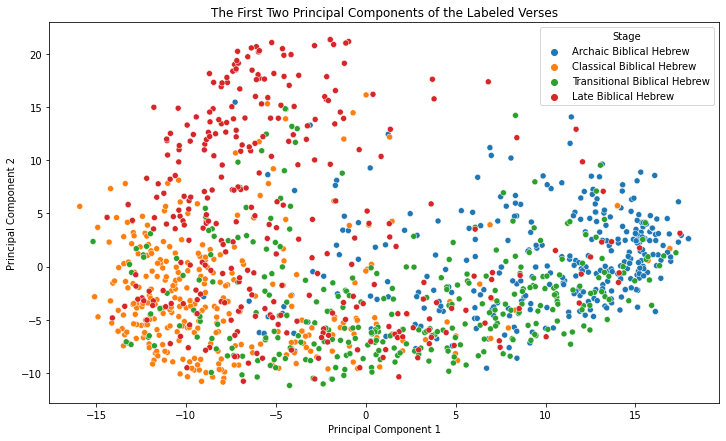

In [37]:
plt.figure(figsize=(12,7))
sns.scatterplot(x='PC1', y='PC2', data=pc, hue='Stage')
plt.title('The First Two Principal Components of the Labeled Verses')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show();

The groupings are not as clear as I would have hoped. Although ABH, CBH, and to a lesser extent LBH cluster in distinct regions of the graph, TBH is much more diffuse, overlapping significantly with ABH and CBH. It is important to remember, however, that language change is a slow, continous process. For every linguistic feature that changes, many others remain the same. Areas of overlap between the different stages may represent verses that contain fewer distinctive chronological features. It's also possible that the four groups are more easily distinguishable in higher dimensions. 

The position of TBH is particulalry strange because TBH represents the transitional phase between CBH and LBH and so we would expect it to overlap with these groups. One possible explanation for this outcome is that TBH texts contains a mixture of poetry and prose, while CBH and ABH texts are predominantly written in either poetry (ABH) or prose (CBH). But such a hypothesis does not not explain why TBH does not overlap as much with LBH, which is also written primarily in prose. 

As a final test, let's see how the actual grouping compares to the clusters generated by an unsupersived learning algorithm. 

In [42]:
agg = AgglomerativeClustering(n_clusters=4)
clustering = agg.fit(pc[['PC1', 'PC2']])
pc['Label'] = clustering.labels_

replacement_vals = {0: "Classical Biblical Hebrew", 1: "Transitional Biblical Hebrew", 2 : "Late Biblical Hebrew",  3 : "Archaic Biblical Hebrew"}
pc.replace(replacement_vals, inplace = True)

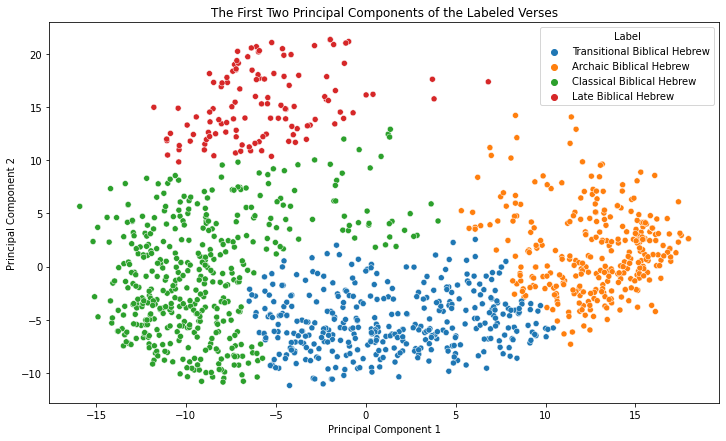

In [43]:
plt.figure(figsize=(12,7))
sns.scatterplot(x='PC1', y='PC2', data=pc, hue='Label')
plt.title('The First Two Principal Components of the Labeled Verses')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show();

In [52]:
replacement_vals = {"Archaic Biblical Hebrew" : 0, "Classical Biblical Hebrew" : 1, "Transitional Biblical Hebrew" : 2, "Late Biblical Hebrew" : 3}

pc.replace(replacement_vals, inplace=True)

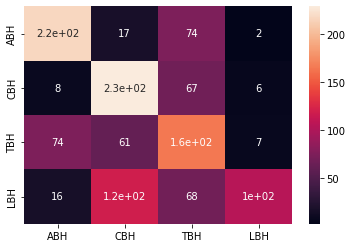

In [53]:
sns.heatmap(confusion_matrix(pc['Stage'], pc['Label']), annot=True, xticklabels=['ABH', 'CBH', 'TBH', 'LBH'], yticklabels=['ABH', 'CBH', 'TBH', 'LBH'])
plt.show()

Well that's a relief! The actual grouping matches the clusters generated by unsupervised learning remarkably well for ABH, CBH, and TBH. LBH remain problematic, having lost nearly half of its datapoints to CBH. But I feel more confident now that the verse embeddings capture chronological information.  